# Task 1:  Discriminative Models – CNN vs. ViT Inductive Biases: 

### Importing libraries


Importing the necessary libraries for the task.

In [1]:
import os
import torch
import numpy as np
import torchvision
import pathlib
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import tqdm
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score
from torch import nn
from torchinfo import summary
import seaborn as sns
from sklearn.metrics import classification_report
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights
from sklearn.manifold import TSNE
import random


### Creating Dataset Directory

Creating the directories in which the STL-10 data will be stored, and best model-params will be stored.

In [2]:
root = pathlib.Path("./data")
params_dir = pathlib.Path("./models")

if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists(params_dir):
    os.mkdir(params_dir)

### Downloading Image Preprocessing Transforms

We use the default transforms associated with ResNet50_Weights.IMAGENET1K_V1 and ViT_B_16_Weights.IMAGENET1K_V1. The documentation for these weights and their corresponding transforms can be found here https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html, https://docs.pytorch.org/vision/0.19/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16.

Additionally, the mean and standard deviation used for image normalization are stored for later use during image visualization. Notably, both ViT-B-16 and ResNet-50 share the same default transforms when using the specified weights. This allows the same dataset to be used for fine-tuning both models.

In [3]:
weights = ResNet50_Weights.IMAGENET1K_V1
transform = weights.transforms()  

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])

### Downloading the STL-10 Dataset and visualizing data

The STL-10 dataset is an image dataset with few labelled examples, and is used for unsupervised pre-training. The dimensions of the images are 96 by 96, with three channels. A more detailed overview of the data can be found here https://cs.stanford.edu/~acoates/stl10/.

In [4]:
dataset = torchvision.datasets.STL10(root, transform=transform, download=True)
trainset, testset = torch.utils.data.random_split(dataset, [0.5, 0.5])
classes = dataset.classes
print("Classes: ", classes)

100%|██████████| 2.64G/2.64G [02:51<00:00, 15.4MB/s] 


Classes:  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=os.cpu_count())
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=os.cpu_count())

In [8]:
def show_images(ims: torch.tensor, labels: torch.tensor):
    fig, axes = plt.subplots(1, len(ims))
    fig.subplots_adjust(wspace=0, hspace=0)
    titles= [classes[i] for i in labels]
  
    for im, title, ax in zip(ims, titles, axes):
        im = im.permute(1, 2, 0)
        im = im*std+mean
        ax.imshow(im) 
        ax.axis('off')
        ax.set_title(title)

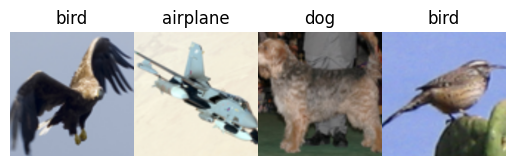

In [9]:
n_samples = 4
X, Y = next(iter(train_loader))
ims, labels = X[:n_samples], Y[:n_samples] 

show_images(ims, labels)

### Training, Testing and Evaluation Functions

Here we define the functions which will be used to train, test and evaluate the models. In addition, The provided functions are device-agnostic.

In [26]:
def metrics(y_preds: torch.tensor, y: torch.tensor, num_classes: int,):
    y_preds, y = y_preds.cpu(), y.cpu()
    confmat = ConfusionMatrix('multiclass', num_classes=num_classes)
    return {"confmat" : confmat(y_preds, y),"classification_report":classification_report(y, y_preds.argmax(axis=1))}

def train_step(train_loader: torch.utils.data.DataLoader, model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device), model.train()
    train_loss, num_correct = 0, 0

    for X,Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds,Y)
        num_correct += sum(preds.argmax(axis=1)==Y).item()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss/=len(train_loader)
    acc = num_correct/(len(train_loader.dataset))
    print(f"\nTrain loss: {train_loss:.5f} |  Train acc: {acc*100:.2f} %\n", flush=True)
    return train_loss, acc

def test_step(test_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device), model.eval()
    test_loss, num_correct = 0, 0

    with torch.inference_mode():
        for X,Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds,Y).item()
            num_correct += sum(preds.argmax(axis=1)==Y).item()

    test_loss /= len(test_loader)
    acc = num_correct/len(test_loader.dataset)
    print(f"Test loss: {test_loss:.5f} | Test acc: {acc*100:.2f} %\n", flush=True)
    return test_loss, acc

def train(train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, epochs: int, optimizer: torch.optim.Optimizer, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
   
    for epoch in tqdm.trange(epochs):
        print(f"epoch: {epoch+1}")
        train_loss, train_acc = train_step(train_loader, model, optimizer, loss_fn, device)
        test_loss, test_acc = test_step(test_loader, model, loss_fn, device)
        train_losses.append(train_loss), train_accuracies.append(train_acc)
        test_losses.append(test_loss), test_accuracies.append(test_acc)

    return train_losses, test_losses, train_accuracies, test_accuracies

def eval_model(test_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device,):
    all_preds, all_targets = [], []
    model.to(device), model.eval()
    loss, num_correct = 0, 0

    with torch.inference_mode():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss += loss_fn(preds, Y)
            num_correct += sum(preds.argmax(axis=1)==Y).item()
            all_preds.append(preds.cpu())
            all_targets.append(Y.cpu())

        loss /= len(test_loader)
        all_preds = torch.concat(all_preds, dim=0)
        all_targets = torch.concat(all_targets, dim=0)
    
    return metrics(all_preds, all_targets, num_classes=len(test_loader.dataset.classes),)


def display_metrics(metrics: dict, classes: list[str]):
    print(metrics["classification_report"])
    sns.heatmap(metrics['confmat'], cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes)
    plt.show()

def plot_dynamics(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    fig, axes= plt.subplots(1,2)
    fig.suptitle("Training Dynamics")
    fig.set_size_inches(10, 3)
    ax1, ax2 = axes

    ax1.set_title("Accuracies")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.plot(train_acc_hist, label="Train")
    ax1.plot(test_acc_hist, label="Test")
    ax1.legend()
    ax1.grid(True)

    ax2.set_title("Losses")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.plot(train_loss_hist, label="Train")
    ax2.plot(test_loss_hist, label="Test")
    ax2.legend()
    ax2.grid(True)
    plt.show()
    

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Model modification and Fine-Tuning (Resnet-50)

We use the torch library implementation of resnet50, with it's default transforms (ResNet50_Weights.IMAGENET1K_V2). documentation regarding the weights and its transforms can be found here https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html. 

In [ ]:

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,)

In [ ]:
for p in model.parameters():
    p.requires_grad = False

num_ft = model.fc.in_features
model.fc = torch.nn.Linear(num_ft, len(classes)).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
num_params 

In [ ]:
epochs = 6
train_losses, test_losses, train_accuracies, test_accuracies=train(train_loader,
                        test_loader,epochs, optimizer,  model, loss_fn, device)

In [ ]:
plot_dynamics(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
m = eval_model(test_loader, model, loss_fn, device)
display_metrics(m, classes)

In [ ]:
m = eval_model(train_loader, model, loss_fn, device)
display_metrics(m, classes)

In [ ]:
PATH = params_dir / "resnet"
torch.save(model.fc.state_dict(), PATH)

### Model modification and Fine-Tuning (ViT)

We use the torch library implementation of ViT-B-16, with it's default transforms (ViT_B_16_Weights.IMAGENET1K_V1). documentation regarding the weights and its transforms can be found here https://docs.pytorch.org/vision/0.19/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16. 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1)
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,)

In [ ]:
for p in model.parameters():
    p.requires_grad = False

num_ft = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_ft, len(classes)).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
num_params

In [ ]:
epochs = 6
train_losses, test_losses, train_accuracies, test_accuracies=train(train_loader,
                        test_loader,epochs, optimizer,  model, loss_fn, device)

In [ ]:
plot_dynamics(train_losses, test_losses, train_accuracies, test_accuracies)

In [ ]:
m = eval_model(test_loader, model, loss_fn, device)
display_metrics(m, classes)

In [ ]:
m = eval_model(train_loader, model, loss_fn, device)
display_metrics(m, classes)

In [ ]:
PATH = params_dir / "vit"
torch.save(model.heads.head.state_dict(), PATH)

In [7]:
def load_resnet(path:str|pathlib.Path):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    num_ft = model.fc.in_features
    model.fc = torch.nn.Linear(num_ft, len(classes)).to(device)
    model.fc.load_state_dict(torch.load(path, weights_only=True))
    return model

def load_vit(path:str|pathlib.Path):
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    num_ft = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(num_ft, len(classes)).to(device)
    model.heads.head.load_state_dict(torch.load(path, weights_only=True))
    return model    


### Creating Transforms

Here we create the transforms that will be used for analysis. 

In [5]:
import torch.nn.functional as F
import random

class ShufflePatches(object): #transform taken from stack overflow https://stackoverflow.com/questions/66962837/shuffle-patches-in-image-batch
  def __init__(self, patch_size):
    self.ps = patch_size

  def __call__(self, x):
    batch_dim = x.ndim == 4
    if not batch_dim:
      x = x.unsqueeze(dim=0)
    
    u = F.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
    pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
    f = F.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    
    if batch_dim:
      return f
    
    return f.squeeze(dim=0)

def plot_sample(raw:torch.utils.data.Dataset, transform:nn.Module,seed:int=100):
  random.seed(seed)
  X, Y = random.choice(raw)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(8, 4)
  fig.suptitle(classes[Y])
  ax1, ax2 = axes
  ax1.imshow(transform(X).squeeze().permute(1, 2, 0))
  ax2.imshow(X)
  ax1.axis("off")
  ax2.axis("off")
  
  
shuffle_ims = v2.Compose([transform, ShufflePatches(patch_size=16)])
gray_scale = v2.Compose([transform, v2.Grayscale()])
occlusion = v2.Compose([transform, v2.RandomErasing(p=1.0, scale=(0.3, 0.4),)])
affine = v2.Compose([transform,  v2.RandomAffine(degrees=0, translate=(0.2, 0.2))])

In [11]:
random.seed(100)
raw = torchvision.datasets.STL10(root)

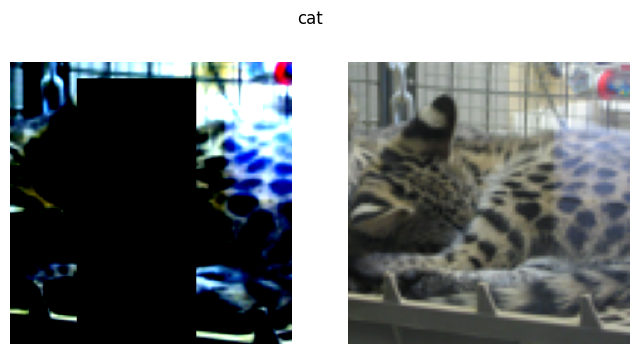

In [203]:
plot_sample(raw, occlusion)

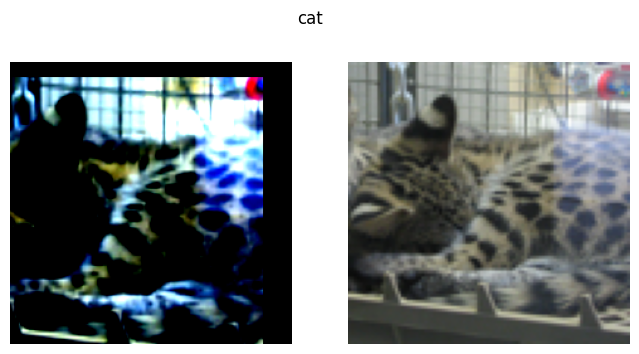

In [207]:
plot_sample(raw, affine)

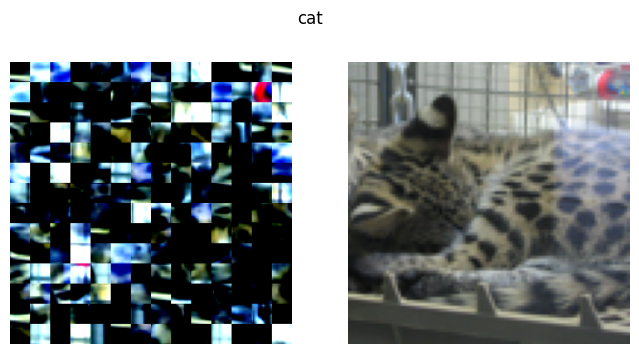

In [209]:
plot_sample(raw, shuffle_ims)

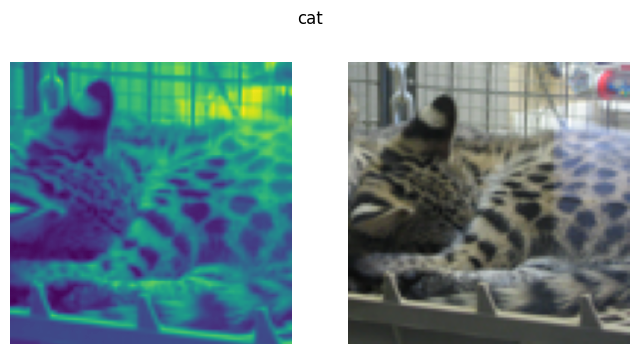

In [208]:
plot_sample(raw, gray_scale)


### Style Transfer

In [6]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import PIL

_="https://www.kaggle.com/models/google/arbitrary-image-stylization-v1/frameworks/TensorFlow1/variations/256/versions/2"
style_transfer_model=hub.load(_)

2025-09-19 21:14:22.848243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758316463.070614      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758316463.133714      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1758316479.122442      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [26]:
def load_image(path):
    return PIL.Image.open(path)

pre_ = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=256),
])

post_ = v2.Compose([
    v2.CenterCrop(size=224),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

def to_tf(tensor:torch.Tensor):
    np_tensor = tensor.detach().cpu().numpy()
    tf_tensor = tf.convert_to_tensor(np_tensor)
    if len(tf_tensor.shape)<4:
        tf_tensor = tf_tensor[tf.newaxis, :]
    return tf.transpose(tf_tensor, perm=[0,2,3,1])

def to_pt(tensor:tf.Tensor):
    np_tensor = tensor.numpy()
    pt_tensor = torch.Tensor(np_tensor)
    if pt_tensor.dim()<4:
        pt_tensor = torch.unsqueeze(pt_tensor, dim=0)
    return torch.permute(pt_tensor, [0, 3, 1, 2])


class StyleTransform(nn.Module):
    def __init__(self, style_path: str):
        super().__init__()
        style_image = load_image(style_path)
        style = pre_(style_image)
        self.style = to_tf(style)
    
    def forward(self, X):
        content = to_tf(X)
        cast = style_transfer_model(tf.constant(content),tf.constant(self.style))[0]
        out = to_pt(cast)
        return out


class StyleDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, base:torch.utils.data.Dataset, root: str, style_path , pre_= None, post_= None, 
                 batch_size: int = 128, 
                 num_workers: int = os.cpu_count()):
       
        self.pre_ = pre_
        self.post_ = post_
    
        dataset = base(root=root, transform=pre_)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
        self.style_transform = StyleTransform(style_path)
        
        stylized = []
        labels = []
        for X, Y in loader:
            stylized.append(self.style_transform(X))
            labels.append(Y)
            

        self.stylized = torch.cat(stylized, dim=0)
        self.labels = torch.cat(labels)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        X, Y = self.stylized[idx], self.labels[idx]  

       
        if self.post_ is not None:
            X = self.post_(X)
        return X, Y

# plt.imshow(styleTransform(content).permute(1, 2, 0))


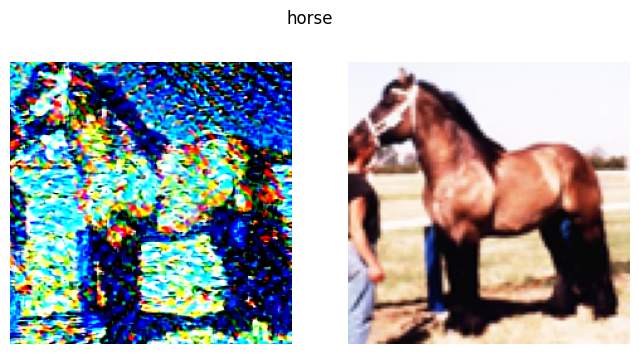

In [29]:
styleTransform = StyleTransform(style_path='styles/image.png')

plot_sample(raw, v2.Compose([pre_,styleTransform, post_]), seed=2445)


In [30]:
dataset = StyleDatasetWrapper(torchvision.datasets.STL10, root, 'styles/image.png', pre_=pre_, post_=post_)

In [31]:
model = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1)

In [ ]:
features, labels = get_features(model, dataset, type="vit")


progress : 1|79
progress : 6|79
progress : 11|79
progress : 16|79


### Feature Extraction and Visualization

In [23]:
def get_features(model:nn.Module, dataset:torch.utils.data.Dataset, type:str, batch_size:int =64, device:torch.device="cpu"):
    
    features = []
    def pre_forward_hook_fn(module, input,):
        features.append(input[0].detach().cpu())

    if type == "resnet":
        handle = model.fc.register_forward_pre_hook(pre_forward_hook_fn,)
    elif type == "vit":
        handle = model.heads.head.register_forward_pre_hook(pre_forward_hook_fn,)

    model.eval() 
    model.to(device)

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
    labels = []

    with torch.inference_mode():
        for i, (X,Y) in enumerate(loader):
            X, Y = X.to(device), Y.to(device)
            _ = model(X)
            labels.append(Y)
            if i%5 == 0:
                print(f"progress : {len(labels)}|{len(loader)}")

        handle.remove()
        
    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

def tsne_plot(latents, labels, num_samples=1000, perplexity=30):
    if latents.shape[0] > num_samples:
        idx = torch.randperm(latents.shape[0])[:num_samples]
        latents = latents[idx]
        labels = labels[idx]

    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', random_state=3231)

    z_embed = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_embed[:, 0], z_embed[:, 1], c=labels, cmap="tab10", s=5, alpha=0.7)
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.ax.set_yticklabels(classes)
    cbar.set_label("STL10 Classes")

    plt.title("t-SNE of Features")
    # plt.savefig("figures/VAE_TSNE.png", dpi=300, bbox_inches='tight')
    # plt.close()


In [67]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [68]:
features, labels = get_features(model, testset, type="resnet")


progress : 1|79
progress : 6|79
progress : 11|79
progress : 16|79
progress : 21|79
progress : 26|79
progress : 31|79
progress : 36|79
progress : 41|79
progress : 46|79
progress : 51|79
progress : 56|79
progress : 61|79
progress : 66|79
progress : 71|79
progress : 76|79


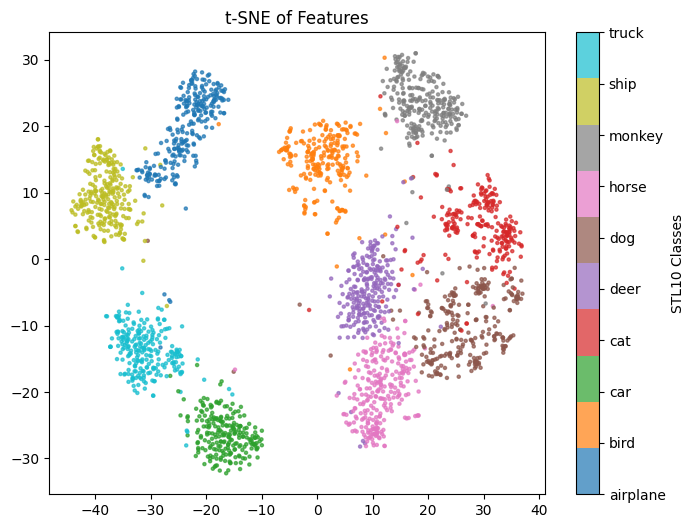

In [72]:
tsne_plot(features, labels, num_samples=2500, perplexity=50)

In [73]:
model = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 141MB/s] 


In [77]:
features, labels = get_features(model, testset, type="vit")


progress : 1|79
progress : 6|79
progress : 11|79
progress : 16|79
progress : 21|79
progress : 26|79
progress : 31|79
progress : 36|79
progress : 41|79
progress : 46|79
progress : 51|79
progress : 56|79
progress : 61|79
progress : 66|79
progress : 71|79
progress : 76|79


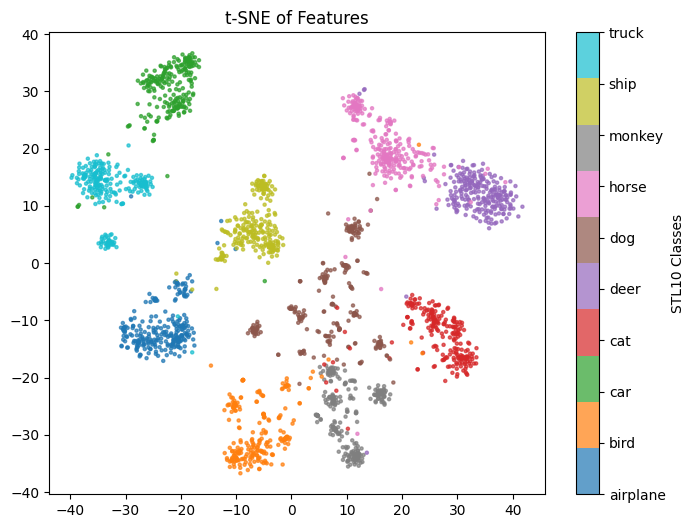

In [78]:
tsne_plot(features, labels, num_samples=2500, perplexity=50)

### FineTuning on PACS

In [8]:
pacs_root = root / "pacs"

def get_pacs_dataset(domain:str, transform:callable = None):
    return torchvision.datasets.ImageFolder(pacs_root / domain, transform=transform)

def get_union_pacs_dataset(domains:str, transform:callable = None):
    ds = [get_pacs_dataset(domain, transform) for domain in domains]
    return torch.utils.data.ConcatDataset(ds)


In [ ]:
classes = os.listdir(pacs_root / 'sketch')

def config_layers(modules:nn.Module | list[nn.Module], freeze:bool=False):
    if isinstance(modules, (list, tuple)):
        for module in modules:
            config_layers(module, freeze)
    else:
        for p in modules.parameters():
            p.requires_grad = not freeze


def init_model(type:str, num_classes:int, freeze_backbone:bool=False):
    if type == "vit":
        model = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1)
        if freeze_backbone:
            config_layers(model, freeze=True)
        num_ft = model.heads.head.in_features
        model.heads.head = torch.nn.Linear(num_ft, num_classes).to(device)
      
    elif type == "resnet":
        model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
        if freeze_backbone:
            config_layers(model, freeze=True)
        num_ft = model.fc.in_features
        model.fc = torch.nn.Linear(num_ft, num_classes).to(device)
    return model
  

def configure_layers_vit(vit:nn.Module, layers:list[int], freeze:bool = True):
    layer_maps = [vit.encoder.layers[i] for i in layers] 
    config_layers(layer_maps, freeze)


def configure_layers_resnet(resnet:nn.Module, layers:list[int], freeze:bool = True):
    layer_maps = [getattr(resnet, f"layer{i}") for i in layers] 
    config_layers(layer_maps, freeze)


def train_workflow(model:nn.Module, train_dataset:torch.utils.data.Dataset, val_dataset:torch.utils.data.Dataset, config:dict):
    epochs         = config.get('epochs', 5)
    lr             = config.get('lr', 1e-5)
    weight_decay   = config.get('weight_decay', 0.0)
    batch_size     = config.get('batch_size', 32)
    momentum       = config.get('momentum', 0.0)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
    
    train_losses, test_losses, train_accuracies, test_accuracies=train(train_loader,
                        val_loader, epochs, optimizer, model, loss_fn, device)
    
    plot_dynamics(train_losses, test_losses, train_accuracies, test_accuracies)
    m = eval_model(val_loader, model, loss_fn, device)
    display_metrics(m, classes)
   

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1

Train loss: 0.88039 |  Train acc: 75.93 %

Test loss: 1.43687 | Test acc: 42.84 %



 20%|██        | 1/5 [00:21<01:25, 21.30s/it]

epoch: 2

Train loss: 0.47600 |  Train acc: 87.18 %

Test loss: 1.40830 | Test acc: 46.14 %



 40%|████      | 2/5 [00:42<01:04, 21.34s/it]

epoch: 3

Train loss: 0.39256 |  Train acc: 88.77 %

Test loss: 1.34846 | Test acc: 47.54 %



 60%|██████    | 3/5 [01:03<00:42, 21.28s/it]

epoch: 4

Train loss: 0.35960 |  Train acc: 89.19 %

Test loss: 1.26229 | Test acc: 51.31 %



 80%|████████  | 4/5 [01:25<00:21, 21.27s/it]

epoch: 5

Train loss: 0.33017 |  Train acc: 89.85 %

Test loss: 1.26910 | Test acc: 52.41 %



100%|██████████| 5/5 [01:46<00:00, 21.28s/it]


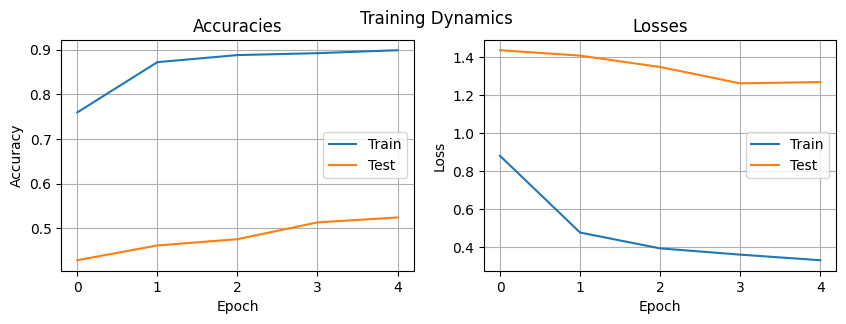

              precision    recall  f1-score   support

           0       0.55      0.23      0.32       772
           1       0.46      0.69      0.55       740
           2       0.53      0.60      0.57       753
           3       0.91      0.81      0.86       608
           4       0.55      0.36      0.44       816
           5       1.00      0.23      0.37        80
           6       0.21      0.71      0.32       160

    accuracy                           0.52      3929
   macro avg       0.60      0.52      0.49      3929
weighted avg       0.58      0.52      0.52      3929



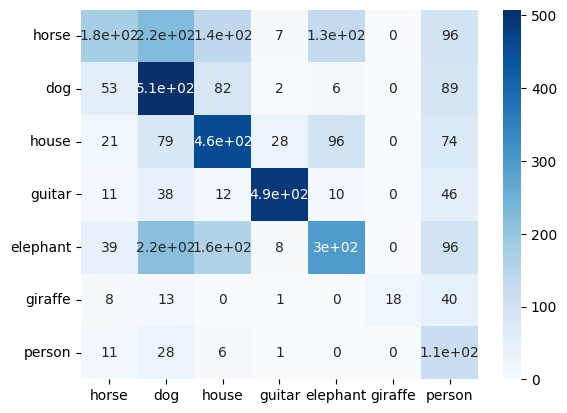

In [35]:
#we train only the head of the model  (Initializing Classifier Weights (Warm Start, WS))
model = init_model('resnet', freeze_backbone=True, num_classes=len(classes))
config = {'epochs':5, 'lr':1e-2, 'batch_size':32}
train_workflow(model, 
               get_union_pacs_dataset(['art_painting', 'cartoon', 'photo'], transform=transform), 
               get_pacs_dataset('sketch', transform=transform), 
               config=config)

In [41]:
# configure_layers_resnet(model, layers=[3,4], freeze=False)
model = init_model('resnet', freeze_backbone=False, num_classes=len(classes))
config = {'epochs':20, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-4}
train_workflow(model, 
               get_union_pacs_dataset(['art_painting', 'cartoon', 'photo'], transform=transform), 
               get_pacs_dataset('sketch', transform=transform), 
               config=config)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1

Train loss: 1.49083 |  Train acc: 56.57 %

Test loss: 1.70585 | Test acc: 38.00 %



  5%|▌         | 1/20 [00:42<13:20, 42.13s/it]

epoch: 2

Train loss: 0.89383 |  Train acc: 83.29 %

Test loss: 1.50351 | Test acc: 46.55 %



 10%|█         | 2/20 [01:24<12:38, 42.14s/it]

epoch: 3

Train loss: 0.57204 |  Train acc: 89.26 %

Test loss: 1.34000 | Test acc: 53.32 %



 15%|█▌        | 3/20 [02:06<11:56, 42.13s/it]

epoch: 4

Train loss: 0.40624 |  Train acc: 90.91 %

Test loss: 1.24377 | Test acc: 57.70 %



 20%|██        | 4/20 [02:48<11:14, 42.14s/it]

epoch: 5

Train loss: 0.31306 |  Train acc: 92.84 %

Test loss: 1.13284 | Test acc: 61.21 %



 25%|██▌       | 5/20 [03:30<10:32, 42.14s/it]

epoch: 6

Train loss: 0.25472 |  Train acc: 93.83 %

Test loss: 1.02949 | Test acc: 65.16 %



 30%|███       | 6/20 [04:12<09:50, 42.16s/it]

epoch: 7

Train loss: 0.21995 |  Train acc: 94.84 %

Test loss: 0.97981 | Test acc: 67.07 %



 35%|███▌      | 7/20 [04:55<09:07, 42.15s/it]

epoch: 8

Train loss: 0.19141 |  Train acc: 95.28 %

Test loss: 1.00386 | Test acc: 63.43 %



 40%|████      | 8/20 [05:37<08:25, 42.15s/it]

epoch: 9

Train loss: 0.16333 |  Train acc: 95.93 %

Test loss: 0.91982 | Test acc: 66.58 %



 45%|████▌     | 9/20 [06:19<07:43, 42.10s/it]

epoch: 10

Train loss: 0.14798 |  Train acc: 96.22 %

Test loss: 0.91989 | Test acc: 66.53 %



 50%|█████     | 10/20 [07:01<07:00, 42.10s/it]

epoch: 11

Train loss: 0.12660 |  Train acc: 96.95 %

Test loss: 0.90109 | Test acc: 67.45 %



 55%|█████▌    | 11/20 [07:43<06:18, 42.09s/it]

epoch: 12

Train loss: 0.11224 |  Train acc: 97.46 %

Test loss: 0.87532 | Test acc: 67.52 %



 60%|██████    | 12/20 [08:25<05:36, 42.08s/it]

epoch: 13

Train loss: 0.10390 |  Train acc: 97.28 %

Test loss: 0.87056 | Test acc: 67.14 %



 65%|██████▌   | 13/20 [09:07<04:55, 42.15s/it]

epoch: 14

Train loss: 0.08920 |  Train acc: 98.20 %

Test loss: 0.86531 | Test acc: 68.34 %



 70%|███████   | 14/20 [09:49<04:12, 42.14s/it]

epoch: 15

Train loss: 0.08102 |  Train acc: 98.19 %

Test loss: 0.87590 | Test acc: 67.70 %



 75%|███████▌  | 15/20 [10:31<03:30, 42.12s/it]

epoch: 16

Train loss: 0.07822 |  Train acc: 98.12 %

Test loss: 0.88441 | Test acc: 67.50 %



 80%|████████  | 16/20 [11:13<02:48, 42.11s/it]

epoch: 17

Train loss: 0.06376 |  Train acc: 98.80 %

Test loss: 0.87806 | Test acc: 68.08 %



 85%|████████▌ | 17/20 [11:56<02:06, 42.11s/it]

epoch: 18


 85%|████████▌ | 17/20 [12:19<02:10, 43.47s/it]


KeyboardInterrupt: 

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1

Train loss: 0.84492 |  Train acc: 77.85 %

Test loss: 1.50444 | Test acc: 36.04 %



 20%|██        | 1/5 [01:08<04:33, 68.48s/it]

epoch: 2

Train loss: 0.40430 |  Train acc: 90.71 %

Test loss: 1.46683 | Test acc: 40.04 %



 40%|████      | 2/5 [02:17<03:25, 68.52s/it]

epoch: 3

Train loss: 0.31629 |  Train acc: 92.44 %

Test loss: 1.48004 | Test acc: 39.37 %



 60%|██████    | 3/5 [03:25<02:16, 68.47s/it]

epoch: 4

Train loss: 0.27181 |  Train acc: 93.24 %

Test loss: 1.46209 | Test acc: 40.93 %



 80%|████████  | 4/5 [04:33<01:08, 68.43s/it]

epoch: 5

Train loss: 0.24312 |  Train acc: 94.16 %

Test loss: 1.47620 | Test acc: 39.22 %



100%|██████████| 5/5 [05:42<00:00, 68.42s/it]


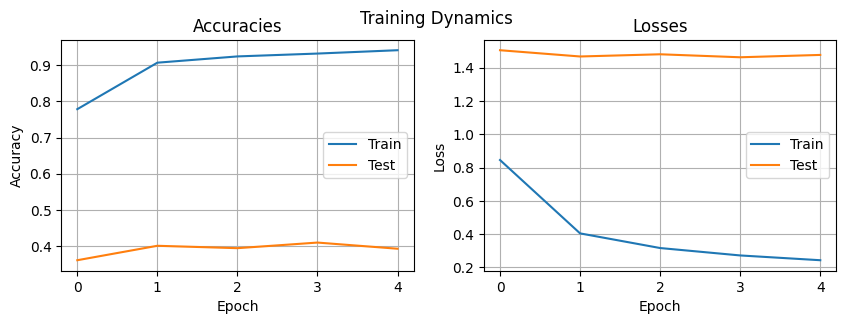

              precision    recall  f1-score   support

           0       0.43      0.12      0.19       772
           1       0.29      0.99      0.45       740
           2       0.66      0.38      0.48       753
           3       1.00      0.40      0.58       608
           4       0.75      0.17      0.28       816
           5       1.00      0.15      0.26        80
           6       0.11      0.23      0.15       160

    accuracy                           0.39      3929
   macro avg       0.61      0.35      0.34      3929
weighted avg       0.60      0.39      0.37      3929



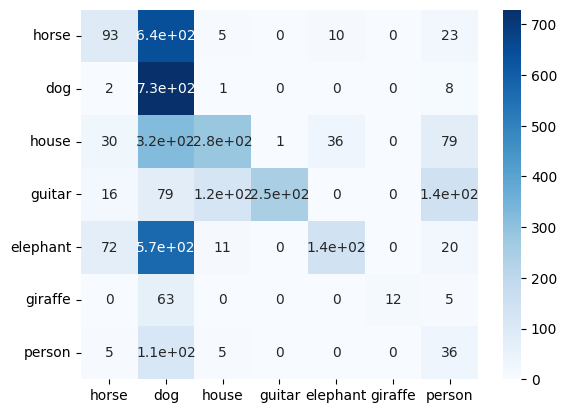

In [42]:
model = init_model('vit', freeze_backbone=True, num_classes=len(classes))
config = {'epochs':5, 'lr':1e-2, 'batch_size':32}
train_workflow(model, 
               get_union_pacs_dataset(['art_painting', 'cartoon', 'photo'], transform=transform), 
               get_pacs_dataset('sketch', transform=transform), 
               config=config)

In [47]:
model = init_model('vit', freeze_backbone=False, num_classes=len(classes))
config = {'epochs':20, 'lr':1e-3, 'batch_size':16, 'weight_decay':5e-4}
train_workflow(model, 
               get_union_pacs_dataset(['art_painting', 'cartoon', 'photo'], transform=transform), 
               get_pacs_dataset('sketch', transform=transform), 
               config=config)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1

Train loss: 1.07256 |  Train acc: 72.76 %

Test loss: 1.56857 | Test acc: 38.28 %



  5%|▌         | 1/20 [02:24<45:42, 144.34s/it]

epoch: 2

Train loss: 0.36135 |  Train acc: 93.52 %

Test loss: 1.16290 | Test acc: 57.14 %



 10%|█         | 2/20 [04:48<43:13, 144.10s/it]

epoch: 3

Train loss: 0.18012 |  Train acc: 96.16 %

Test loss: 1.04800 | Test acc: 62.51 %



 15%|█▌        | 3/20 [07:12<40:47, 143.99s/it]

epoch: 4


: 

In [136]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a